<h1><center>ФБ-33 Stogniychuk Inna</center></h1>
<h2><center>Лабораторна робота №7</center></h2>
<h3><center>Сценарії обробки багатоспектральних супутникових зображень</center></h3>

In [1]:
import os
import zipfile
import rasterio
import sklearn.metrics
from sentinelhub import SHConfig
from sentinelhub.aws import request
from sentinelhub.aws import request
from typing import List
import subprocess
import traceback
import geopandas as gpd
from shapely.geometry import Polygon
from pylandsat.download import Product
import matplotlib.pyplot as plt




<frozen abc>:106: SHDeprecationWarning: AWS functionality will remain in the codebase for now, but won't be actively maintained.
C:\Users\dipaj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\rasterio\path.py:15: RasterioDeprecationWarning: rasterio.path will be removed in version 1.4.
  warnings.warn(


### 1. Завантажити необхідні дані Sentinel-2

In [7]:
data_dir = "sentinel_data"
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
    print(f"Створено папку для даних: '{data_dir}'")
else:
    print(f"Папка для даних '{data_dir}' вже існує.")

# Встановлення конфігурації для Sentinel Hub
config = SHConfig()

product_ids = [
    "S2A_MSIL2A_20190821T085601_N0213_R007_T36UUA_20190821T115206",
    "S2A_MSIL2A_20190821T085601_N0213_R007_T36UUB_20190821T115206",
]


def download_data__sentinel(product_ids, data_dir):
    
    for product_id in product_ids:
        try:
            request.download_safe_format(product_id, folder=data_dir, redownload=False, data_collection='sentinel-s2-l2a')
        except Exception as e:
            traceback.print_exc()

download_data__sentinel(product_ids, data_dir)



Створено папку для даних: 'sentinel_data'


C:\Users\dipaj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sentinelhub\aws\request.py:237: SHDeprecationWarning: Class `AwsProductRequest` has been deprecated. It will remain in the codebase for now, but won't be actively maintained.
  safe_request = AwsProductRequest(product_id, data_folder=folder, bands=bands, safe_format=True)
C:\Users\dipaj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sentinelhub\aws\request.py:88: SHDeprecationWarning: Class `AwsProduct` has been deprecated. It will remain in the codebase for now, but won't be actively maintained.
  self.aws_service = product_class(
C:\Users\dipaj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sentinelhub\aws\data.py:349: SHDeprecationWarning: Class `AwsDownloadClient` has been deprecated. It will r

### 2. Засобами командного рядка операційної системи (демонстраційні приклади розглянуті для ОС Windows), а також за допомогою бінаріїв бібліотеки GDAL розробити автоматичний сценарій, який здійснюватиме обробку даних ДЗЗ, відповідно до поставлених завдань. Для виконання команд gdal у сценарії Python можна використовувати бібліотеки os та command. Над завантаженими даними Sentinel-2 відпрацювати наступні дії.


### – Розпакування наборів архівів з продуктами ДЗЗ в новостворені папки, назви яких відповідатимуть ідентифікаторам зображень.

In [35]:

directory = "lab"

all_files = os.listdir(directory)

# Відфільтрувати файли, щоб залишити тільки zip-архіви
archive_files = [f for f in all_files if f.endswith('.zip')]
 
output_folder = os.path.join(directory, 'ready_files')
os.makedirs(output_folder, exist_ok=True)

def extract_archive(archive_path, extract_to):
    try:
        with zipfile.ZipFile(archive_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
        print(f"Розпаковано '{archive_path}' до '{extract_to}'")
    except zipfile.BadZipFile:
        print(f"Помилка: '{archive_path}' не є дійсним zip-файлом.")
    except Exception as e:
        print(f"Виникла помилка при розпакуванні '{archive_path}': {e}")

for archive_file in archive_files:
    archive_path = os.path.join(directory, archive_file)
    extract_archive(archive_path, output_folder)

print("Усі архіви успішно розпаковані.")


Розпаковано 'lab\S2A_MSIL2A_20190821T085601_N0213_R007_T36UUA_20190821T115206.zip' до 'lab\ready_files'
Розпаковано 'lab\S2A_MSIL2A_20190821T085601_N0213_R007_T36UUB_20190821T115206.zip' до 'lab\ready_files'
Усі архіви успішно розпаковані.


### - Конкатенація каналів видимого, ближнього та середнього інфрачервоного спектральних діапазонів (канали 2, 3, 4 та 8) зображення в єдиний GEOTIFF файл.

In [2]:
import os
from osgeo import gdal

def concatenate_bands(dir, output_file, letter, x):
    if x == '10m':
        band = 'B08'
    else:
        band = 'B8A'

    # Шляхи до файлів
    files = [
        os.path.join(dir, 'GRANULE', f'L2A_T36UU{letter}_A021740_20190821T085815', 'IMG_DATA', f'R{x}', f'T36UU{letter}_20190821T085601_B02_{x}.jp2'),
        os.path.join(dir, 'GRANULE', f'L2A_T36UU{letter}_A021740_20190821T085815', 'IMG_DATA', f'R{x}', f'T36UU{letter}_20190821T085601_B03_{x}.jp2'),
        os.path.join(dir, 'GRANULE', f'L2A_T36UU{letter}_A021740_20190821T085815', 'IMG_DATA', f'R{x}', f'T36UU{letter}_20190821T085601_B04_{x}.jp2'),
        os.path.join(dir, 'GRANULE', f'L2A_T36UU{letter}_A021740_20190821T085815', 'IMG_DATA', f'R{x}', f'T36UU{letter}_20190821T085601_{band}_{x}.jp2')
    ]

    # Перевірка на відсутність файлів
    missing_files = [file for file in files if not os.path.exists(file)]   

    if missing_files:
        print(f"Не знайдено файли: {missing_files}")
    else:
        # Створення вихідного файлу за допомогою GDAL
        input_ds = []
        for file in files:
            ds = gdal.Open(file)
            input_ds.append(ds)

        # Отримуємо розміри та географічні параметри з першого файлу
        driver = gdal.GetDriverByName('GTiff')
        out_ds = driver.Create(output_file, input_ds[0].RasterXSize, input_ds[0].RasterYSize, len(files), gdal.GDT_Byte)

        # Переносимо географічну інформацію з першого файлу
        out_ds.SetGeoTransform(input_ds[0].GetGeoTransform())
        out_ds.SetProjection(input_ds[0].GetProjection())

        # Записуємо кожен канал
        for i, ds in enumerate(input_ds):
            out_ds.GetRasterBand(i+1).WriteArray(ds.GetRasterBand(1).ReadAsArray())

        # Закриття вихідного файлу
        out_ds = None

        print(f"Конкатенований канал збережено в файл '{output_file}'")


product_ids = {
    "S2A_MSIL2A_20190821T085601_N0213_R007_T36UUA_20190821T115206.SAFE": "A",
    "S2A_MSIL2A_20190821T085601_N0213_R007_T36UUB_20190821T115206.SAFE": "B",
}

# Вказуємо основну директорію
data_dir_1 = r"C:\Users\dipaj\Desktop\lab\ready_files"

# Директорія для вихідних файлів
output_folder1 = os.path.join(data_dir_1, 'ready_files')
os.makedirs(output_folder1, exist_ok=True)

def prompt_overwrite(file_path):
    while True:
        response = input(f"Файл '{file_path}' вже існує. Перезаписати його? (yes/no): ").lower()
        if response in ['yes', 'no']:
            return response == 'yes'

xm = ['10m', '20m', '60m']

for product_id, letter in product_ids.items():
    product_dir = os.path.join(data_dir_1, product_id)
    for x in xm:
        output_file = os.path.join(output_folder1, f"{letter}_concatenated_{x}.tif")
        
        if os.path.exists(output_file):
            if prompt_overwrite(output_file):
                os.remove(output_file)
                concatenate_bands(product_dir, output_file, letter, x)
        else:
            concatenate_bands(product_dir, output_file, letter, x)


C:\Users\dipaj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\osgeo\gdal.py:314: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


Конкатенований канал збережено в файл 'C:\Users\dipaj\Desktop\lab\ready_files\ready_files\A_concatenated_10m.tif'


Файл 'C:\Users\dipaj\Desktop\lab\ready_files\ready_files\A_concatenated_20m.tif' вже існує. Перезаписати його? (yes/no):  yes


Конкатенований канал збережено в файл 'C:\Users\dipaj\Desktop\lab\ready_files\ready_files\A_concatenated_20m.tif'


Файл 'C:\Users\dipaj\Desktop\lab\ready_files\ready_files\A_concatenated_60m.tif' вже існує. Перезаписати його? (yes/no):  yes


Конкатенований канал збережено в файл 'C:\Users\dipaj\Desktop\lab\ready_files\ready_files\A_concatenated_60m.tif'


Файл 'C:\Users\dipaj\Desktop\lab\ready_files\ready_files\B_concatenated_10m.tif' вже існує. Перезаписати його? (yes/no):  yes


Конкатенований канал збережено в файл 'C:\Users\dipaj\Desktop\lab\ready_files\ready_files\B_concatenated_10m.tif'


Файл 'C:\Users\dipaj\Desktop\lab\ready_files\ready_files\B_concatenated_20m.tif' вже існує. Перезаписати його? (yes/no):  yes


Конкатенований канал збережено в файл 'C:\Users\dipaj\Desktop\lab\ready_files\ready_files\B_concatenated_20m.tif'


Файл 'C:\Users\dipaj\Desktop\lab\ready_files\ready_files\B_concatenated_60m.tif' вже існує. Перезаписати його? (yes/no):  yes


Конкатенований канал збережено в файл 'C:\Users\dipaj\Desktop\lab\ready_files\ready_files\B_concatenated_60m.tif'


CRS of 'C:\Users\dipaj\Desktop\lab\ready_files\ready_files\A_concatenated_10m.tif': EPSG:32636


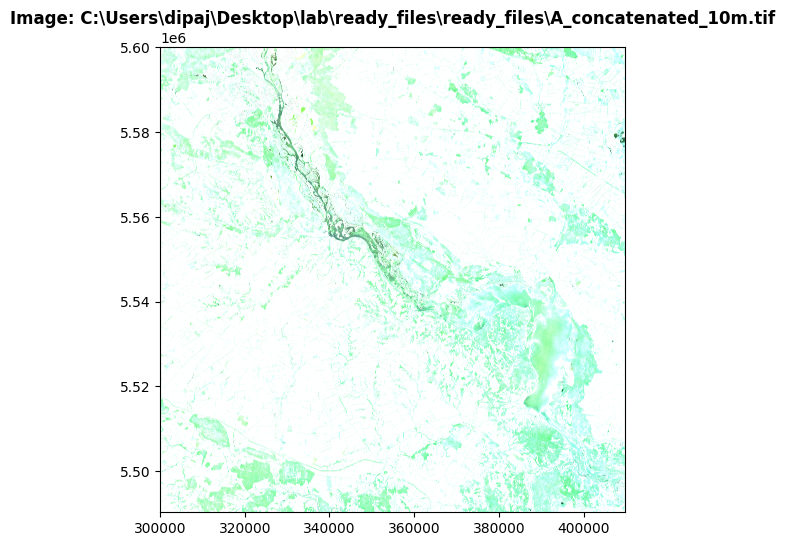

CRS of 'C:\Users\dipaj\Desktop\lab\ready_files\ready_files\A_concatenated_20m.tif': EPSG:32636


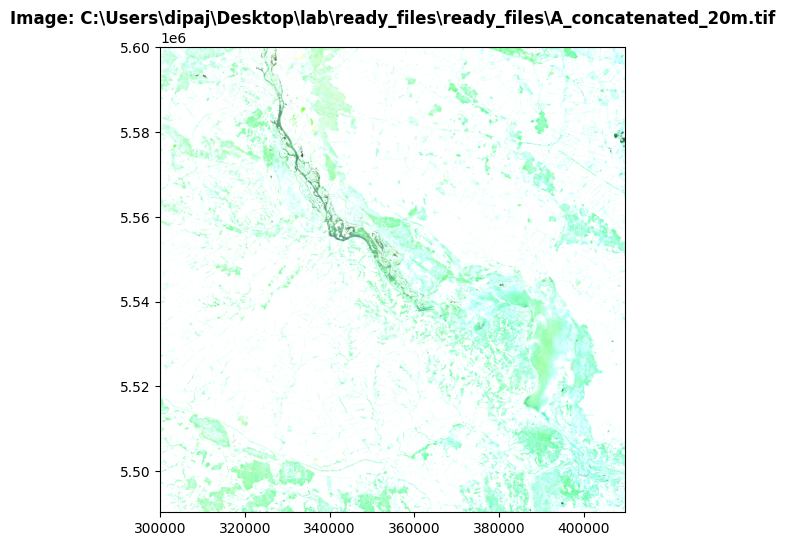

CRS of 'C:\Users\dipaj\Desktop\lab\ready_files\ready_files\A_concatenated_60m.tif': EPSG:32636


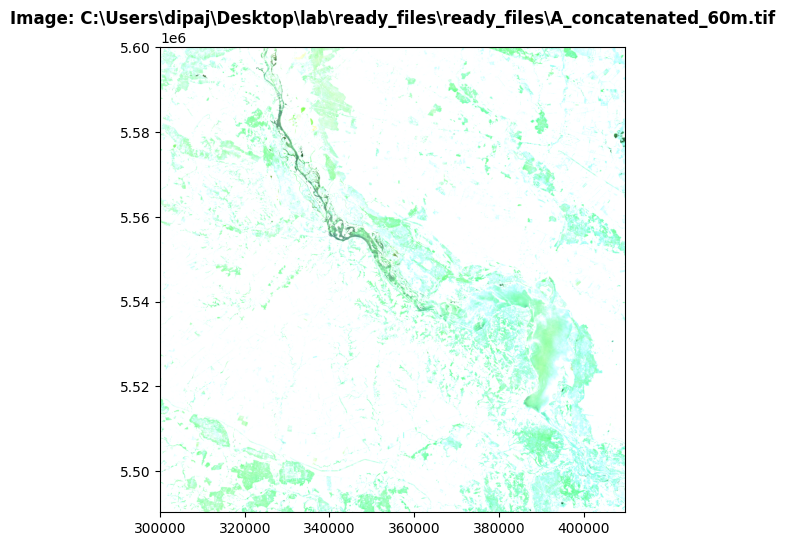

CRS of 'C:\Users\dipaj\Desktop\lab\ready_files\ready_files\B_concatenated_10m.tif': EPSG:32636


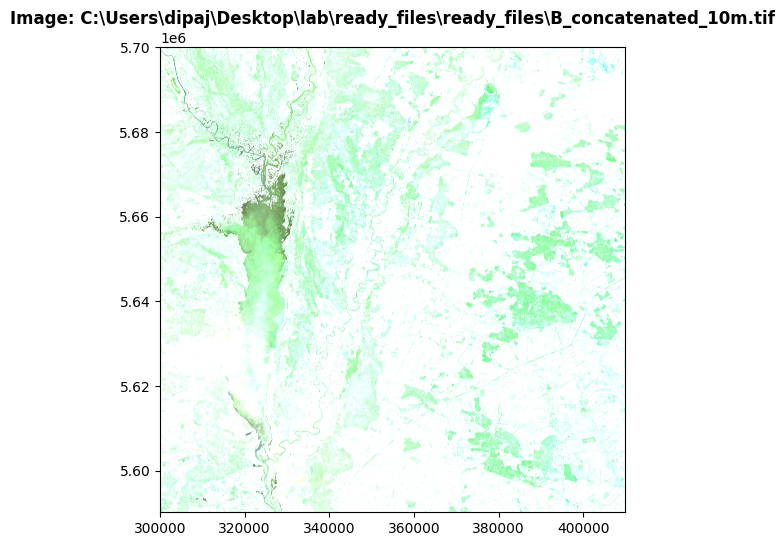

CRS of 'C:\Users\dipaj\Desktop\lab\ready_files\ready_files\B_concatenated_20m.tif': EPSG:32636


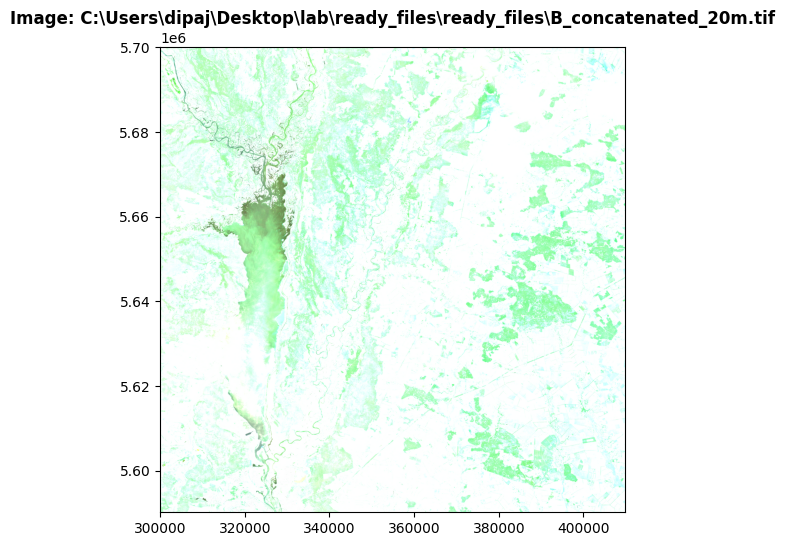

CRS of 'C:\Users\dipaj\Desktop\lab\ready_files\ready_files\B_concatenated_60m.tif': EPSG:32636


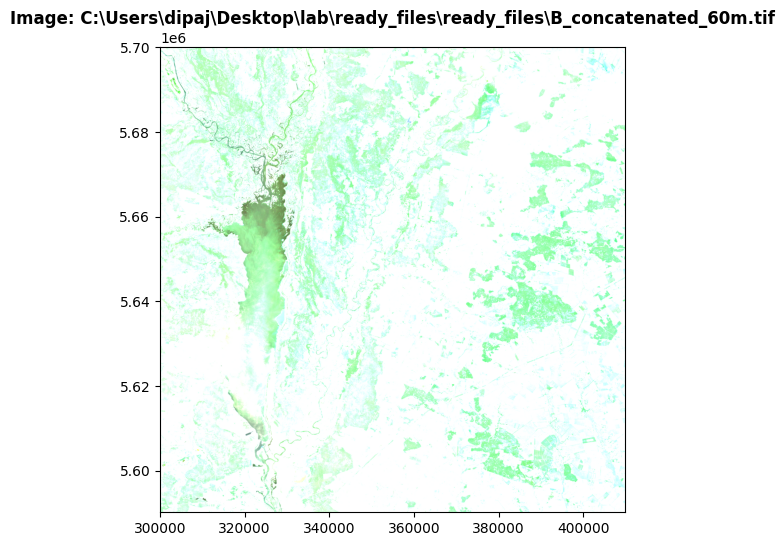

In [3]:
from rasterio.plot import show
import rasterio
import matplotlib.pyplot as plt

def print_image(file_path):
    try:
        with rasterio.open(file_path) as src:
            print(f"CRS of '{file_path}': {src.crs}")
            
            fig, ax = plt.subplots(figsize=(6, 8))
            show(src, ax=ax, title=f"Image: {file_path}")
            plt.show()
    except Exception as e:
        print(f"Помилка при обробці файлу '{file_path}': {e}")
        
product_ids = {
    "S2A_MSIL2A_20190821T085601_N0213_R007_T36UUA_20190821T115206.SAFE": "A",
    "S2A_MSIL2A_20190821T085601_N0213_R007_T36UUB_20190821T115206.SAFE": "B",
}
data_dir_2 = r"C:\Users\dipaj\Desktop\lab\ready_files"
xm = ['10m', '20m', '60m']
output_folder1 = os.path.join(data_dir_2, 'ready_files')
    
for product_id, letter in product_ids.items():
    product_dir = os.path.join(data_dir_2, product_id)
    for x in xm:
        output_file = os.path.join(output_folder1, f"{letter}_concatenated_{x}.tif")
        print_image(output_file)

### – Перепроектування супутникового зображення у проєкцію 4326.

In [4]:
from osgeo import gdal
import os

def reproject_image(input_file, output_file, target_srs='EPSG:4326'):
    if os.path.exists(output_file):
        os.remove(output_file)
        print(f"Output file '{output_file}' вже існував і був видалений.")

    try:
        gdal.UseExceptions()
        gdal.Warp(
            destNameOrDestDS=output_file,
            srcDSOrSrcDSTab=input_file,
            dstSRS=target_srs
        )
        print(f"Репроєкція збережена до '{output_file}'")
    except Exception as e:
        print(f" Помилка при репроєкції '{input_file}': {e}")

# Продовження твого коду
for product_id, letter in product_ids.items():
    for x in xm:
        input_file = os.path.join(output_folder1, f"{letter}_concatenated_{x}.tif")
        output_file = os.path.join(output_folder1, f"{letter}_reprojected4326_{x}.tif")

        if os.path.exists(input_file):
            reproject_image(input_file, output_file)
        else:
            print(f"⚠️ Вхідний файл '{input_file}' не знайдено.")



Output file 'C:\Users\dipaj\Desktop\lab\ready_files\ready_files\A_reprojected4326_10m.tif' вже існував і був видалений.
Репроєкція збережена до 'C:\Users\dipaj\Desktop\lab\ready_files\ready_files\A_reprojected4326_10m.tif'
Output file 'C:\Users\dipaj\Desktop\lab\ready_files\ready_files\A_reprojected4326_20m.tif' вже існував і був видалений.
Репроєкція збережена до 'C:\Users\dipaj\Desktop\lab\ready_files\ready_files\A_reprojected4326_20m.tif'
Output file 'C:\Users\dipaj\Desktop\lab\ready_files\ready_files\A_reprojected4326_60m.tif' вже існував і був видалений.
Репроєкція збережена до 'C:\Users\dipaj\Desktop\lab\ready_files\ready_files\A_reprojected4326_60m.tif'
Output file 'C:\Users\dipaj\Desktop\lab\ready_files\ready_files\B_reprojected4326_10m.tif' вже існував і був видалений.
Репроєкція збережена до 'C:\Users\dipaj\Desktop\lab\ready_files\ready_files\B_reprojected4326_10m.tif'
Output file 'C:\Users\dipaj\Desktop\lab\ready_files\ready_files\B_reprojected4326_20m.tif' вже існував і був

CRS of 'C:\Users\dipaj\Desktop\lab\ready_files\ready_files\A_reprojected4326_10m.tif': EPSG:4326


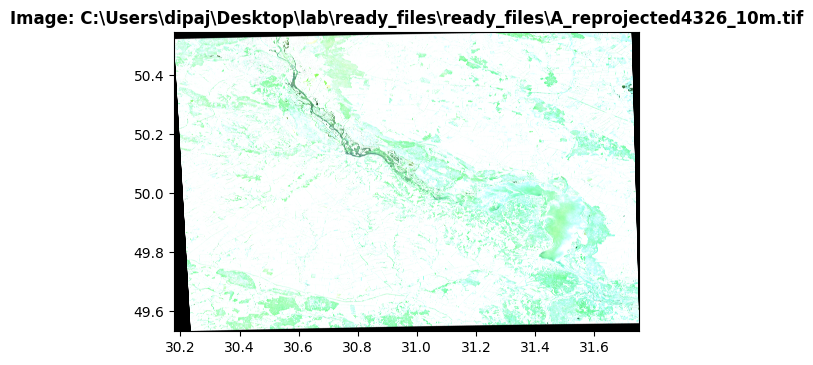

CRS of 'C:\Users\dipaj\Desktop\lab\ready_files\ready_files\A_reprojected4326_20m.tif': EPSG:4326


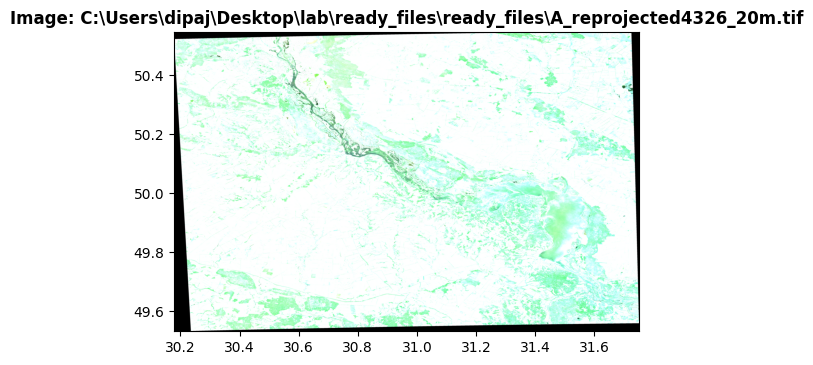

CRS of 'C:\Users\dipaj\Desktop\lab\ready_files\ready_files\A_reprojected4326_60m.tif': EPSG:4326


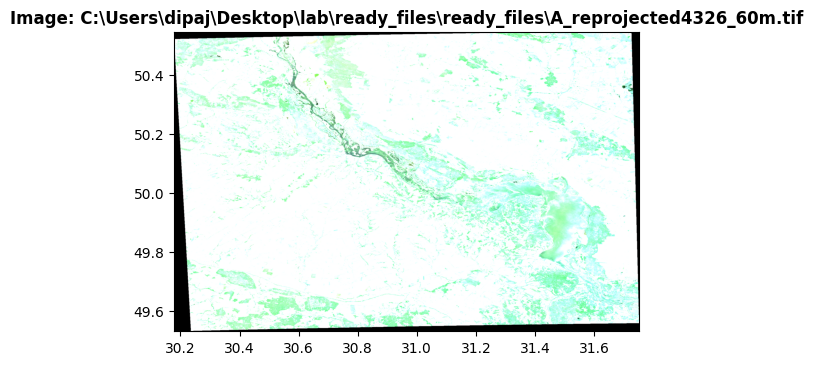

CRS of 'C:\Users\dipaj\Desktop\lab\ready_files\ready_files\B_reprojected4326_10m.tif': EPSG:4326


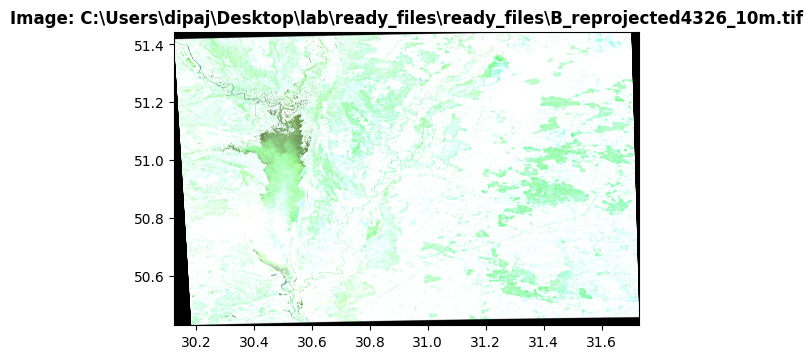

CRS of 'C:\Users\dipaj\Desktop\lab\ready_files\ready_files\B_reprojected4326_20m.tif': EPSG:4326


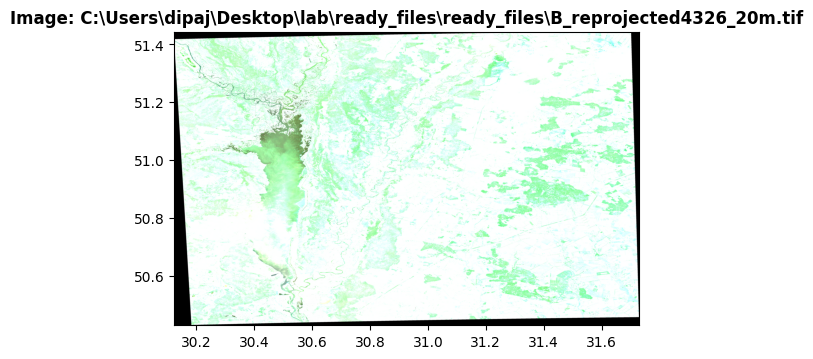

CRS of 'C:\Users\dipaj\Desktop\lab\ready_files\ready_files\B_reprojected4326_60m.tif': EPSG:4326


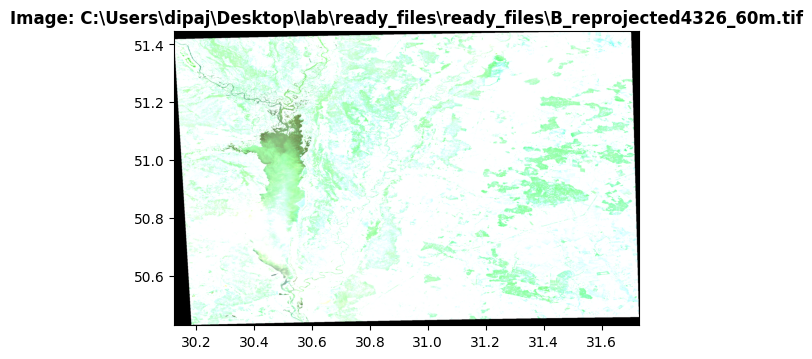

In [13]:
for product_id, letter in product_ids.items():
    
    for x in xm:
        output_file = os.path.join(output_folder1, f"{letter}_reprojected4326_{x}.tif")
        print_image(output_file)

### - Конкатенація всіх отриманих растрів у один 4-канальний файл TIFF.

In [6]:
from osgeo import gdal
import os

def prompt_overwrite(file_path):
    while True:
        response = input(f"Файл '{file_path}' вже існує. Перезаписати його? (yes/no): ").lower()
        if response in ['yes', 'no']:
            return response == 'yes'

def merge_files(output_file, input_files):
    if os.path.exists(output_file):
        if prompt_overwrite(output_file):
            os.remove(output_file)
            print(f"Старий файл '{output_file}' видалено.")
        else:
            print(f"Не перезаписано файл '{output_file}'.")
            return

    # Створюємо віртуальне об'єднання файлів
    vrt_path = output_file + '.vrt'
    vrt = gdal.BuildVRT(vrt_path, input_files, separate=True)
    if vrt is None:
        print(f"❌ Помилка при створенні VRT для {output_file}")
        return

    # Перетворюємо VRT у реальний файл
    gdal.Translate(output_file, vrt)
    print(f"✅ Файл '{output_file}' створено.")

    # Безпечне видалення VRT
    if os.path.exists(vrt_path):
        os.remove(vrt_path)

# Файли
concatenated_files = [
    ('concatenated_10m.tif', ['A_concatenated_10m.tif', 'B_concatenated_10m.tif']),
    ('concatenated_20m.tif', ['A_concatenated_20m.tif', 'B_concatenated_20m.tif']),
    ('concatenated_60m.tif', ['A_concatenated_60m.tif', 'B_concatenated_60m.tif'])
]

reprojected_files = [
    ('reprojected4326_10m.tif', ['A_reprojected4326_10m.tif', 'B_reprojected4326_10m.tif']),
    ('reprojected4326_20m.tif', ['A_reprojected4326_20m.tif', 'B_reprojected4326_20m.tif']),
    ('reprojected4326_60m.tif', ['A_reprojected4326_60m.tif', 'B_reprojected4326_60m.tif'])
]


# Шлях до фінальної папки
final_dir = 'sentinel_data/final_images'
os.makedirs(final_dir, exist_ok=True)

# Об'єднання
for output_file, input_files in concatenated_files:
    output_path = os.path.join(final_dir, output_file)
    input_paths = [os.path.join(output_folder1, file) for file in input_files]
    merge_files(output_path, input_paths)

for output_file, input_files in reprojected_files:
    output_path = os.path.join(final_dir, output_file)
    input_paths = [os.path.join(output_folder1, file) for file in input_files]
    merge_files(output_path, input_paths)


Файл 'sentinel_data/final_images\concatenated_10m.tif' вже існує. Перезаписати його? (yes/no):  yes


Старий файл 'sentinel_data/final_images\concatenated_10m.tif' видалено.
✅ Файл 'sentinel_data/final_images\concatenated_10m.tif' створено.


Файл 'sentinel_data/final_images\concatenated_20m.tif' вже існує. Перезаписати його? (yes/no):  yes


Старий файл 'sentinel_data/final_images\concatenated_20m.tif' видалено.
✅ Файл 'sentinel_data/final_images\concatenated_20m.tif' створено.
✅ Файл 'sentinel_data/final_images\concatenated_60m.tif' створено.
✅ Файл 'sentinel_data/final_images\reprojected4326_10m.tif' створено.
✅ Файл 'sentinel_data/final_images\reprojected4326_20m.tif' створено.
✅ Файл 'sentinel_data/final_images\reprojected4326_60m.tif' створено.


### - Обрізання результуючого зображення по заданому векторному контуру.


In [12]:

# Координати полігону для Києва (WGS84 — EPSG:4326)
coordinates = [(29.073321247506765, 49.845775018245774),
               (31.986007792928522, 49.845775018245774),
               (31.986007792928522, 51.278667808079206),
               (29.073321247506765, 51.278667808079206),
               (29.073321247506765, 49.845775018245774)]

# Створення полігону та GeoDataFrame з CRS
polygon = Polygon(coordinates)
gdf = gpd.GeoDataFrame(geometry=[polygon], crs="EPSG:4326")

# Збереження shapefile
output_shapefile = "sentinel_data/final_images/Kyiv_regions.shp"
gdf.to_file(output_shapefile)

print(f"✅ Shapefile збережено з CRS EPSG:4326: {output_shapefile}")


✅ Shapefile збережено з CRS EPSG:4326: sentinel_data/final_images/Kyiv_regions.shp


In [13]:
import os
from osgeo import gdal

def clip_image(input_image, output_image, shapefile):
    # Перевірка наявності всіх необхідних файлів shapefile
    required_ext = ['.shp', '.shx', '.dbf']
    for ext in required_ext:
        if not os.path.exists(shapefile.replace('.shp', ext)):
            print(f"[ПОМИЛКА] Відсутній файл shapefile з розширенням {ext}")
            return

    # Налаштування обрізки
    options = gdal.WarpOptions(
        cutlineDSName=shapefile,
        cropToCutline=True,
        dstNodata=0  # або інше значення для фону
    )

    # Виконання обрізки
    result = gdal.Warp(output_image, input_image, options=options)

    if result is None:
        print(f"[ПОМИЛКА] Не вдалося обрізати зображення '{input_image}'")
    else:
        print(f"✅ Зображення обрізано. Результат збережено: '{output_image}'")

# === Параметри ===
final_dir = 'sentinel_data/final_images'
shapefile = os.path.join(final_dir, 'Kyiv_regions.shp')

concatenated_files = [
    'concatenated_10m.tif', 'concatenated_20m.tif', 'concatenated_60m.tif'
]

reprojected_files = [
    'reprojected4326_10m.tif', 'reprojected4326_20m.tif', 'reprojected4326_60m.tif'
]

# === Обрізка concatenated файлів ===
for file in concatenated_files:
    input_image = os.path.join(final_dir, file)
    output_image = os.path.join(final_dir, f'cut_{file}')
    clip_image(input_image, output_image, shapefile)

# === Обрізка reprojected файлів ===
for file in reprojected_files:
    input_image = os.path.join(final_dir, file)
    output_image = os.path.join(final_dir, f'cut_{file}')
    clip_image(input_image, output_image, shapefile)


✅ Зображення обрізано. Результат збережено: 'sentinel_data/final_images\cut_concatenated_10m.tif'
✅ Зображення обрізано. Результат збережено: 'sentinel_data/final_images\cut_concatenated_20m.tif'
✅ Зображення обрізано. Результат збережено: 'sentinel_data/final_images\cut_concatenated_60m.tif'
✅ Зображення обрізано. Результат збережено: 'sentinel_data/final_images\cut_reprojected4326_10m.tif'
✅ Зображення обрізано. Результат збережено: 'sentinel_data/final_images\cut_reprojected4326_20m.tif'
✅ Зображення обрізано. Результат збережено: 'sentinel_data/final_images\cut_reprojected4326_60m.tif'


### 3. Протестувати різні реалізовані в gdal методи паншарпенінгу.

### Завантаження Landsat-8

In [3]:

scene_ids = [
    "LC08_L1TP_182025_20190830_20190903_01_T1",
    "LC08_L1TP_182026_20190830_20190903_01_T1"
]

output_dir = 'landsat_downloads'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for scene_id in scene_ids:
    product = Product(scene_id)
    scene_dir = os.path.join(output_dir, scene_id)

    try:
        print(f"Завантаження знімка {scene_id}...")
        product.download(scene_dir, progressbar=True, verify=False)
        print(f"Знімок {scene_id} завантажено успішно.")
    except Exception as e:
        print(f"Помилка завантаження знімка {scene_id}: {e}")
        continue


    if os.path.isdir(scene_dir):
        contents = os.listdir(scene_dir)
        if f"{scene_id}_B1.TIF" in contents and f"{scene_id}_MTL.txt" in contents:
            print(f"Знімок {scene_id} завантажено успішно.")
    else:
        print(f"Помилка завантаження знімка {scene_id}: каталог не створено.")

Завантаження знімка LC08_L1TP_182025_20190830_20190903_01_T1...


LC08_L1TP_182025_20190830_20190903_01_T1_B1.TIF: : 65.0MB [00:19, 3.28MB/s]                                            
LC08_L1TP_182025_20190830_20190903_01_T1_B2.TIF: : 67.1MB [00:18, 3.56MB/s]                                            
LC08_L1TP_182025_20190830_20190903_01_T1_B3.TIF: : 71.3MB [00:19, 3.71MB/s]                                            
LC08_L1TP_182025_20190830_20190903_01_T1_B4.TIF: : 76.5MB [00:24, 3.14MB/s]                                            
LC08_L1TP_182025_20190830_20190903_01_T1_B5.TIF: : 90.2MB [00:25, 3.52MB/s]                                            
LC08_L1TP_182025_20190830_20190903_01_T1_B6.TIF: : 89.1MB [00:27, 3.28MB/s]                                            
LC08_L1TP_182025_20190830_20190903_01_T1_B7.TIF: : 86.0MB [00:22, 3.86MB/s]                                            
LC08_L1TP_182025_20190830_20190903_01_T1_B8.TIF: : 285MB [01:49, 2.60MB/s]                                             
LC08_L1TP_182025_20190830_20190903_01_T1

Знімок LC08_L1TP_182025_20190830_20190903_01_T1 завантажено успішно.
Завантаження знімка LC08_L1TP_182026_20190830_20190903_01_T1...


LC08_L1TP_182026_20190830_20190903_01_T1_B1.TIF: : 66.1MB [00:11, 5.52MB/s]                                            
LC08_L1TP_182026_20190830_20190903_01_T1_B2.TIF: : 69.2MB [00:15, 4.54MB/s]                                            
LC08_L1TP_182026_20190830_20190903_01_T1_B3.TIF: : 73.4MB [00:14, 5.08MB/s]                                            
LC08_L1TP_182026_20190830_20190903_01_T1_B4.TIF: : 78.6MB [00:14, 5.54MB/s]                                            
LC08_L1TP_182026_20190830_20190903_01_T1_B5.TIF: : 90.2MB [00:17, 5.25MB/s]                                            
LC08_L1TP_182026_20190830_20190903_01_T1_B6.TIF: : 87.0MB [00:16, 5.32MB/s]                                            
LC08_L1TP_182026_20190830_20190903_01_T1_B7.TIF: : 84.9MB [00:16, 5.16MB/s]                                            
LC08_L1TP_182026_20190830_20190903_01_T1_B8.TIF: : 289MB [00:54, 5.35MB/s]                                             
LC08_L1TP_182026_20190830_20190903_01_T1

Знімок LC08_L1TP_182026_20190830_20190903_01_T1 завантажено успішно.


### Конкатенація каналів видимого, ближнього та середнього інфрачервоного спектральних діапазонів (канали 2, 3, 4 та 8) зображення в єдиний GEOTIFF файл.

In [19]:
import os
from osgeo import gdal

scene_ids = [
    "LC08_L1TP_182025_20190830_20190903_01_T1",
    "LC08_L1TP_182026_20190830_20190903_01_T1"
]

output_dir = 'landsat_merged'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

landsat_downloads_dir = 'landsat_downloads'

for scene_id in scene_ids:
    scene_dir = os.path.join(landsat_downloads_dir, scene_id, scene_id)
    if not os.path.isdir(scene_dir):
        print(f"Папки зі сценою {scene_id} не знайдено в каталозі {landsat_downloads_dir}")
        continue

    input_files = [
        os.path.join(scene_dir, f"{scene_id}_B2.TIF"),  # Blue
        os.path.join(scene_dir, f"{scene_id}_B3.TIF"),  # Green
        os.path.join(scene_dir, f"{scene_id}_B4.TIF"),  # Red
        os.path.join(scene_dir, f"{scene_id}_B8.TIF")   # Panchromatic
    ]

    for f in input_files:
        if not os.path.exists(f):
            print(f"Файл не знайдено: {f}")
            continue

    vrt_path = os.path.join(output_dir, f"{scene_id}.vrt")
    output_path = os.path.join(output_dir, f"{scene_id}_merged.tif")

    # Створення VRT
    vrt = gdal.BuildVRT(vrt_path, input_files, separate=True)
    if vrt is None:
        print(f"Не вдалося створити VRT для {scene_id}")
        continue

    # Перетворення VRT у GeoTIFF
    gdal.Translate(output_path, vrt)
    vrt = None  # закриваємо

    print(f"Зображення {scene_id} успішно об'єднано у файл {output_path}")


Зображення LC08_L1TP_182025_20190830_20190903_01_T1 успішно об'єднано у файл landsat_merged\LC08_L1TP_182025_20190830_20190903_01_T1_merged.tif
Зображення LC08_L1TP_182026_20190830_20190903_01_T1 успішно об'єднано у файл landsat_merged\LC08_L1TP_182026_20190830_20190903_01_T1_merged.tif


### – Перепроектування супутникового зображення у проєкцію 4326.

In [29]:
from osgeo import gdal
import os

for scene_id in scene_ids:
    
    scene_dir = os.path.join(landsat_downloads_dir, scene_id)
    if not os.path.isdir(scene_dir):
        print(f"Папки зі сценою {scene_id} не знайдено в каталозі {landsat_downloads_dir}")
        continue

    input_file = os.path.join(output_dir, f"{scene_id}_merged.tif")
    output_file_reprojected = os.path.join(output_dir, f"{scene_id}_merged_4326.tif")

    try:
        gdal.Warp(
            destNameOrDestDS=output_file_reprojected,
            srcDSOrSrcDSTab=input_file,
            dstSRS='EPSG:4326'
        )
        print(f"Зображення {scene_id} успішно перепроектовано у проєкцію EPSG:4326.")
    except RuntimeError as e:
        print(f"Помилка під час перепроектування зображення {scene_id} у проєкцію EPSG:4326: {e}")



Зображення LC08_L1TP_182025_20190830_20190903_01_T1 успішно перепроектовано у проєкцію EPSG:4326.
Зображення LC08_L1TP_182026_20190830_20190903_01_T1 успішно перепроектовано у проєкцію EPSG:4326.


### – Конкатенація всіх отриманих растрів у один 4-канальний файл TIFF.

In [32]:
from osgeo import gdal
import os

landsat_merged_dir = 'landsat_merged'

# Вихідний файл після об'єднання оригінальних (не перепроєктованих) зображень
input_files = [
    os.path.join(landsat_merged_dir, "LC08_L1TP_182025_20190830_20190903_01_T1_merged.tif"),
    os.path.join(landsat_merged_dir, "LC08_L1TP_182026_20190830_20190903_01_T1_merged.tif")
]
output_file = os.path.join(landsat_merged_dir, "merged.tif")

# Об'єднання TIFF-файлів у один
gdal.Warp(
    destNameOrDestDS=output_file,
    srcDSOrSrcDSTab=input_files,
    options=gdal.WarpOptions(
        format='GTiff',
        creationOptions=[
            'TILED=YES',
            'COMPRESS=LZW',
            'BIGTIFF=IF_SAFER'
        ]
    )
)
print(f"Файли успішно об'єднані в '{output_file}'.")

# Об'єднання вже перепроєктованих файлів у EPSG:4326
input_files_4326 = [
    os.path.join(landsat_merged_dir, "LC08_L1TP_182025_20190830_20190903_01_T1_merged_4326.tif"),
    os.path.join(landsat_merged_dir, "LC08_L1TP_182026_20190830_20190903_01_T1_merged_4326.tif")
]
output_file_4326 = os.path.join(landsat_merged_dir, "merged_4326.tif")

gdal.Warp(
    destNameOrDestDS=output_file_4326,
    srcDSOrSrcDSTab=input_files_4326,
    options=gdal.WarpOptions(
        format='GTiff',
        creationOptions=[
            'TILED=YES',
            'COMPRESS=LZW',
            'BIGTIFF=IF_SAFER'
        ]
    )
)
print(f"Файли успішно об'єднані в '{output_file_4326}'.")



Файли успішно об'єднані в 'landsat_merged\merged.tif'.
Файли успішно об'єднані в 'landsat_merged\merged_4326.tif'.


In [33]:
from osgeo import gdal
import os

def clip_image_l(input_image, output_image, shapefile):
    # Обрізка зображення по контуру shapefile
    gdal.Warp(
        destNameOrDestDS=output_image,
        srcDSOrSrcDSTab=input_image,
        options=gdal.WarpOptions(
            cutlineDSName=shapefile,
            cropToCutline=True,
            format='GTiff',
            creationOptions=[
                'TILED=YES',
                'COMPRESS=LZW',
                'BIGTIFF=IF_SAFER'
            ]
        )
    )
    print(f"Зображення обрізано. Результат збережено '{output_image}'.")

# Приклади використання
final_dir = 'landsat_merged'
shapefile = os.path.join('sentinel_data', 'final_images', 'Kyiv_regions.shp')

merged_files = [
    'merged_4326.tif', 'merged.tif'
]

for file in merged_files:
    input_image = os.path.join(final_dir, file)
    output_image = os.path.join(final_dir, f'cut_{file}')
    clip_image_l(input_image, output_image, shapefile)


Зображення обрізано. Результат збережено 'landsat_merged\cut_merged_4326.tif'.
Зображення обрізано. Результат збережено 'landsat_merged\cut_merged.tif'.


### Підготуйте склеєні RGB канали Landsat-8 та окремо панхроматичний. Переведіть панхроматичний канал у 30 м, а RGB канали у 60 метрів.


In [43]:
from osgeo import gdal
import os

lansat_dir = 'landsat_downloads'
processed_dir = 'processed_landsat'

if not os.path.exists(processed_dir):
    os.makedirs(processed_dir)

scene_ids = [
    "LC08_L1TP_182025_20190830_20190903_01_T1",
    "LC08_L1TP_182026_20190830_20190903_01_T1"
]

for scene_id in scene_ids:
    scene_path = os.path.join(lansat_dir, scene_id, scene_id)

    # Перевірка існування каналів
    channel_paths = [os.path.join(scene_path, f'{scene_id}_B{i}.TIF') for i in range(2, 5)]
    
    missing_files = [ch for ch in channel_paths if not os.path.exists(ch)]
    
    if missing_files:
        print(f"Не знайдено наступні канали для сцени {scene_id}: {missing_files}")
        continue

    output_merged_path = os.path.join(processed_dir, f'{scene_id}_concatenated.tif')

    vrt_path = os.path.join(processed_dir, f'{scene_id}_temp.vrt')

    # Створення VRT та збереження у файл
    vrt_ds = gdal.BuildVRT(vrt_path, channel_paths, separate=True)

    if vrt_ds is None:
        print(f"Не вдалося створити VRT для сцени {scene_id}. Пропуск...")
        continue
    
    # Конвертація VRT у TIFF
    gdal.Translate(output_merged_path, vrt_ds)
    vrt_ds = None  # Закрити ресурс після конвертації

    # Видалення тимчасового VRT
    os.remove(vrt_path)

    # === Ресемплінг до 60 м ===
    output_resampled_path = os.path.join(processed_dir, f'{scene_id}_60.tif')
    gdal.Translate(
        output_resampled_path,
        output_merged_path,
        xRes=60,
        yRes=60,
        resampleAlg='bilinear'
    )

    # === Ресемплінг PAN (канал 8) до 30 м ===
    pan_path = os.path.join(scene_path, f'{scene_id}_B8.TIF')
    output_pan_resampled_path = os.path.join(processed_dir, f'{scene_id}_30.tif')
    gdal.Translate(
        output_pan_resampled_path,
        pan_path,
        xRes=30,
        yRes=30,
        resampleAlg='bilinear'
    )

print("Зображення оброблено успішно для всіх сцен.")


Зображення оброблено успішно для всіх сцен.


### Після цього паншарпніть 60 метровий RGB за допомогою 30 м панхроматичного каналу. Після цього ви отримуєте два 30 метрових RGB зображення - перший оригінальний, другий паншарпнутий.

In [49]:
from osgeo import gdal
import os

output_pansharpen_dir = 'pansharpen'
if not os.path.exists(output_pansharpen_dir):
    os.makedirs(output_pansharpen_dir)

pansharpen_methods = ['nearest', 'bilinear', 'cubic', 'cubicspline', 'lanczos', 'average']

for scene_id in scene_ids:
    scene_path = os.path.join(lansat_dir, scene_id, scene_id)

    output_pan_resampled_path = os.path.join(processed_dir, f'{scene_id}_30.tif')
    output_resampled_path = os.path.join(processed_dir, f'{scene_id}_60.tif')

    pan_ds = gdal.Open(output_pan_resampled_path)
    rgb_ds = gdal.Open(output_resampled_path)

    if not pan_ds or not rgb_ds:
        print(f"Не вдалося відкрити одне з зображень для сцени {scene_id}. Пропуск...")
        continue

    for method in pansharpen_methods:
        output_file = f'{scene_id}_pansharpen_{method}.tif'
        output_file_path = os.path.join(output_pansharpen_dir, output_file)

        gdal.Translate(output_file_path, rgb_ds, bandList=[1, 2, 3], resampleAlg=method)

        print(f'Паншарпенінг для сцени {scene_id} з методом {method} завершено. Збережено у {output_file_path}')



Паншарпенінг для сцени LC08_L1TP_182025_20190830_20190903_01_T1 з методом nearest завершено. Збережено у pansharpen\LC08_L1TP_182025_20190830_20190903_01_T1_pansharpen_nearest.tif
Паншарпенінг для сцени LC08_L1TP_182025_20190830_20190903_01_T1 з методом bilinear завершено. Збережено у pansharpen\LC08_L1TP_182025_20190830_20190903_01_T1_pansharpen_bilinear.tif
Паншарпенінг для сцени LC08_L1TP_182025_20190830_20190903_01_T1 з методом cubic завершено. Збережено у pansharpen\LC08_L1TP_182025_20190830_20190903_01_T1_pansharpen_cubic.tif
Паншарпенінг для сцени LC08_L1TP_182025_20190830_20190903_01_T1 з методом cubicspline завершено. Збережено у pansharpen\LC08_L1TP_182025_20190830_20190903_01_T1_pansharpen_cubicspline.tif
Паншарпенінг для сцени LC08_L1TP_182025_20190830_20190903_01_T1 з методом lanczos завершено. Збережено у pansharpen\LC08_L1TP_182025_20190830_20190903_01_T1_pansharpen_lanczos.tif
Паншарпенінг для сцени LC08_L1TP_182025_20190830_20190903_01_T1 з методом average завершено. З

### Підрахуйте метрики точності паншарпенінгу (це будь які вам відомі метрики які можна використовувати для валідації регресії, наприклад r square). За даними метриками виберіть найкращий метод паншарпенінгу.

In [57]:
import os
import rasterio
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, max_error
import numpy as np
import pandas as pd

pansharpen_dir = 'pansharpen'
processed_dir = 'processed_landsat'
scene_ids = [
    "LC08_L1TP_182025_20190830_20190903_01_T1",
    "LC08_L1TP_182026_20190830_20190903_01_T1"
]

pansharpen_methods = ['nearest', 'bilinear', 'cubic', 'cubicspline', 'lanczos', 'average']

results = []

for scene_id in scene_ids:
    orig_path = os.path.join(processed_dir, f'{scene_id}_30.tif')
    with rasterio.open(orig_path) as src:
        orig_data = src.read()
        for method in pansharpen_methods:
            pansharpen_path = os.path.join(pansharpen_dir, f'{scene_id}_pansharpen_{method}.tif')
            with rasterio.open(pansharpen_path) as pan:
                pansharpen_data = pan.read()

                if orig_data.shape != pansharpen_data.shape:
                    print(f"Форми масивів не співпадають для Scene ID: {scene_id}, Method: {method}")
                    continue

                # Обчислення метрик
                r2 = r2_score(orig_data.ravel(), pansharpen_data.ravel())
                mse = mean_squared_error(orig_data.ravel(), pansharpen_data.ravel())
                mae = mean_absolute_error(orig_data.ravel(), pansharpen_data.ravel())
                max_err = max_error(orig_data.ravel(), pansharpen_data.ravel())

                # Додавання результатів до списку
                results.append({
                    'Scene ID': scene_id,
                    'Method': method,
                    'R-squared': r2,
                    'MSE': mse,
                    'MAE': mae,
                    'Max Error': max_err
                })


df = pd.DataFrame(results)


if not df.empty:
    print(df)
else:
    print("Немає результатів для відображення.")



Форми масивів не співпадають для Scene ID: LC08_L1TP_182025_20190830_20190903_01_T1, Method: nearest
Форми масивів не співпадають для Scene ID: LC08_L1TP_182025_20190830_20190903_01_T1, Method: bilinear
Форми масивів не співпадають для Scene ID: LC08_L1TP_182025_20190830_20190903_01_T1, Method: cubic
Форми масивів не співпадають для Scene ID: LC08_L1TP_182025_20190830_20190903_01_T1, Method: cubicspline
Форми масивів не співпадають для Scene ID: LC08_L1TP_182025_20190830_20190903_01_T1, Method: lanczos
Форми масивів не співпадають для Scene ID: LC08_L1TP_182025_20190830_20190903_01_T1, Method: average
Форми масивів не співпадають для Scene ID: LC08_L1TP_182026_20190830_20190903_01_T1, Method: nearest
Форми масивів не співпадають для Scene ID: LC08_L1TP_182026_20190830_20190903_01_T1, Method: bilinear
Форми масивів не співпадають для Scene ID: LC08_L1TP_182026_20190830_20190903_01_T1, Method: cubic
Форми масивів не співпадають для Scene ID: LC08_L1TP_182026_20190830_20190903_01_T1, Meth

In [54]:
best_methods = df.loc[df.groupby('Scene ID')['R-squared'].idxmax()]
print("\nНайкращий метод за R-squared для кожної сцени:")
display(best_methods)

[]
